# <style> 
    .ma-classe {
    font-size: 40 px;
}
</style>
<div class="alert alert-warning">  Load Librairies </div>


In [181]:
import torch

In [182]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

import torch.nn as nn
from torch import tensor
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim

import torchvision
from torchvision import utils
import torchvision.transforms as transforms

from tqdm import tqdm 
import copy

from plotly.subplots import make_subplots

from PIL import Image, ImageDraw
import plotly.graph_objs as go

In [183]:
import conf_matrix
from utils.conf_matrix import make_confusion_matrix
from sklearn import metrics

# 1 | Load the data

In [204]:
ORIGINAL = "datasets/"
TRAIN_DIR = ORIGINAL + "mut_effect_train.csv"
TEST_DIR = ORIGINAL + "mut_effect_test.csv"
VAL_DIR =  ORIGINAL + "mut_effect_validation.csv"
UNIPROT_DIR = ORIGINAL + "uniprot_fasta_sequences.csv"

In [205]:
mut_effect_train = pd.read_csv(TRAIN_DIR)
mut_effect_test = pd.read_csv(TEST_DIR)
mut_effect_val = pd.read_csv(VAL_DIR)

uniprot_seq = pd.read_csv(UNIPROT_DIR)

## 1.1 |</span></b> Exploration of the data</div>


### Display the original data  </div>

mut_effect_train, mut_effect_test and mut_effect_test have the same structure. They formed the dataset already divided in three distincts parts : training, testing, validation. 
Here we display the train set. 

In [206]:
mut_effect_train

,uniprot,ftype,pos,ori_res,var_res,desc,no effect,length
0,Q2G160,mutagenesis site,165,K,C,"3125-fold decrease in catalytic activity, and ...",False,293
1,O33599,mutagenesis site,117,N,A,Activates the enzyme.,False,316
2,O33599,mutagenesis site,210,H,A,Inactivates the enzyme.,False,316
3,O33599,mutagenesis site,214,D,A,Inactivates the enzyme.,False,316
4,O33599,mutagenesis site,291,H,A,Inactivates the enzyme.,False,316
...,...,...,...,...,...,...,...,...
46387,C6KT50,mutagenesis site,139,R,A,No activity; when associated with A-136 and A-...,False,301
46388,C6KT50,mutagenesis site,140,R,A,No activity; when associated with A-136 and A-...,False,301
46389,C6KT50,mutagenesis site,151,K,A,No activity. The mutant forms hexamers instead...,False,301
46390,Q8ILG2,mutagenesis site,246,D,A,Loss of catalytic activity.,False,627


The uniprot data contains the correspondences between the uniprot code of the studied proteins and their sequences. 

In [207]:
uniprot_seq

,uniprot,sequence
0,K0F8Z5,MSSEKIQRVGIIGAGQMGAGIAEVCARAHVDVLVYEQTRELAAAGR...
1,K0F1Z7,MTRHVDVLIIGAGLSGIGMACHLTREQTGRSYAILERRAAIGGTWD...
2,K0EI02,MPKARATALITAALIVVVLVAGCTRLVDGRAVSIYDDPFKVAGLPT...
3,K0EPK0,MYSPIEDWDTDEVWMFLMQYANPWGVSNKDLLTMYQGASADSECPL...
4,K0EQ80,MTEASADAAGARRRRNRDIAGRHVLITGASSGIGRAAAIAVAGKGA...
...,...,...
561557,A0A1C1CCI4,MGSIPSDQAVAPPPSTTTYNIASIPADGIGPEVITAGINVLNTLSR...
561558,A0A1C1D2I0,MEMQLRLYVLADRLQAVMLSGIILCEPPIGLPAGSSMKDATRETSP...
561559,A0A1C1CI70,MQYIQTFASCAALIRDPLGHIFAGLPRASAFSAAISSNVALHPPLP...
561560,A0A1C1CC49,MAAGEVPAPAKKRRIGVLTSGGDSPGMNGAVRAVVRMSIHMGCESY...


## 1.2 |</span></b>  New dataset</div>

In order to exploit the data show above, we first extracted the sequences corresponding to the uniprot codes from the dataset "uniprot_seq". Then, thanks to the differents features provided in the original dataset we were able to reconstruct the sequence after mutation. 
Moreover, for each protein we have kept in the last column: the original amino acid, the amino acid that replaced it and finally the position of the mutation in the sequence. This column allowed us to further analyze the performance of our models to see if there was a correlation between a good prediction and the mutated amino acid. 
Finally, the y column corresponds to the label of our model. A 1 means that the mutation had no effect and a 0 the opposite. 


## Load the data  </div>

In order to evaluate the performance of our model, we extracted two datasets: the first one containing 1000 data of proteins with sequence lengths lower than 215 (it was then divided into data_train_215 with 800 data and data_val_215). And a second dataset with 5585 datasets (divided into 4500 for data_train_600 and the rest in data_val_600) and whose data contains proteins with sequence lengths less than 600. 

In [208]:
NEW = "data/"

TRAIN_600 = NEW + "train_set_600.csv"
TRAIN_215 = NEW + "train_set_215.csv"
VAL_600 = NEW + "val_set_600.csv"
VAL_215 = NEW + "val_set_215.csv"

In [209]:
data_train_600 = pd.read_csv(TRAIN_600)
data_val_600 = pd.read_csv(VAL_600)
data_train_215 = pd.read_csv(TRAIN_215)
data_val_215 = pd.read_csv(VAL_215)

In [210]:
data_train_600

,sequence,sequence_mutated,sequence_mask,Y,amino_info
0,MEAPLVSLDEEFEDLRPSCSEDPEEKPQCFYGSSPHHLEDPSLSEL...,MEAPLVSLDEEFEDLRPSCSEDPEEKPQCFYGSSPHHLEDPSLSEL...,MEAPLVSLDEEFEDLRPSCSEDPEEKPQCFYGSSPHHLEDPSLSEL...,1,"('K', 'A', 264)"
1,MGRTFIHASKIKHAARKRKHHSNFRTLIKLLNNDAYKIESSKPLKN...,MGRTFIHASKIKHAARKRKHHSNFRTLIKLLNNDAYKIESSKPLKN...,MGRTFIHASKIKHAARKRKHHSNFRTLIKLLNNDAYKIESSKPLKN...,1,"('W', 'A', 75)"
2,MNKTAIALLALLASSASLAATPWQKITQPVPGSAQSIGSFSNGCIV...,MNKTAIALLALLASSASLAATPWQKITQPVPGSAQSIGSFSNGCIV...,MNKTAIALLALLASSASLAATPWQKITQPVPGSAQSIGSFSNGCIV...,0,"('H', 'A', 113)"
3,MASSTTRGPRVSDLFSGLPPAVTTPANQSAEASAGNGSVAGADAPA...,MASSTTRGPRVSDLFSGLPPAVTTPANQSAEASAGNGSVAGADAPA...,MASSTTRGPRVSDLFSGLPPAVTTPANQSAEASAGNGSVAGADAPA...,1,"('T', 'A', 365)"
4,MRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKIAEMIVGMK...,MRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKIAEMIVGMK...,MRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKIAEMIVGMK...,0,"('E', 'Q', 59)"
...,...,...,...,...,...
4495,MVNPTTSEVQPTMGVKIFSAGVSACLADIITFPLDTAKVRLQIQGE...,MVNPTTSEVQPTMGVKIFSAGVSAALADIITFPLDTAKVRLQIQGE...,MVNPTTSEVQPTMGVKIFSAGVSA?LADIITFPLDTAKVRLQIQGE...,1,"('C', 'A', 25)"
4496,MSTRTPSSSSSRLMLTIGLCFLVALMEGLDLQAAGIAAGGIAQAFA...,MSTRTPSSSSSRLMLTIGLCFLVALMEGLDLQAAGIAAGGIAQAFA...,MSTRTPSSSSSRLMLTIGLCFLVALMEGLDLQAAGIAAGGIAQAFA...,0,"('D', 'A', 75)"
4497,MANYFNTLNLRQQLAQLGKCRFMGRDEFADGASYLQGKKVVIVGCG...,MANYFNTLNLRQQLAQLGKCRFMGRDEFADGASYLQGKKVVIVGCG...,MANYFNTLNLRQQLAQLGKCRFMGRDEFADGASYLQGKKVVIVGCG...,0,"('A', 'S', 71)"
4498,MAQIFNPNPGNTLDTVANALKEQANAANKDVNDAIKALQGTDNADN...,MAQIFNPNPGNTLDTVANALKEQANAANKDVNDAIKALQGTDNADN...,MAQIFNPNPGNTLDTVANALKEQANAANKDVNDAIKALQGTDNADN...,0,"('D', 'V', 76)"


## Load the data cuts around the mutation </div>

Another performance has been evaluated: the performance of our models on sequences of limited size around the mutation position. 
Thus we created 4 different datasets such that the cutoff around the mutation was 5 amino acids on each side, then 10, then 20 and finally 50. 

In [211]:
CUT = "cut/"
VAL_CUT_5 = NEW + CUT + "val_set_215_cut_5.csv"
VAL_CUT_10 = NEW + CUT + "val_set_215_cut_10.csv"
VAL_CUT_20 = NEW + CUT + "val_set_215_cut_20.csv"
VAL_CUT_50 = NEW + CUT + "val_set_215_cut_50.csv"

In [212]:
data_val_cut_5 = pd.read_csv(VAL_CUT_5)
data_val_cut_10 = pd.read_csv(VAL_CUT_10)
data_val_cut_20 = pd.read_csv(VAL_CUT_20)
data_val_cut_50 = pd.read_csv(VAL_CUT_50)

#  <style> 
    .ma-classe {
    font-size: 40px;
}
</style>
<div class="alert alert-danger">2 |</span></b> Residual NN  </div>

## 2.1 |</span></b> Preprocessing </div>

## 2.1.1 |</span></b> Integer encoding </div>

There are 20 different amino acids that can compose our sequences. For each amino acid, an integer has been associated. The sequence of amino acids has been transformed into a sequence of integers.
First we create a dictionary that assigns to each amino acid an integer.

In [213]:
codes = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

def create_dict(codes):
    char_dict = {}
    for index, val in enumerate(codes):
        char_dict[val] = index+1

    return char_dict

char_dict = create_dict(codes)

print(char_dict)
print("Dict Length:", len(char_dict))

{'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20}
Dict Length: 20


This function converts each amino acid sequence into a series of integers as defined above. 

In [214]:
def integer_encoding(seq):
    """
    - Encodes code sequence to integer values.
    - 20 common amino acids are taken into consideration
.
    """
    seq_encode = []
    for code in seq:
        seq_encode.append(char_dict.get(code, 0))

    return seq_encode

## 2.1.2 |</span></b> Padding the sequence </div>

This function takes a sequence and the maximum length value (in our case the value is either 215 or 600). If the length of the sequence is less than the maximum length then it adds zeros on both sides of the sequence so that the length of the sequences is homogeneous in our dataset. 

In [215]:
def pad_seq(seq, max_len):
    
    if len(seq) < max_len:
        num_add = max_len - len(seq)
        each_side = int(num_add/2)
        if ( each_side * 2 != num_add): 
            left = each_side
            right = each_side + 1 
        else : 
            left = each_side
            right = each_side
        out = np.pad(seq, (left, right))
    else:
        out = seq
    return out

## 2.1.3 |</span></b> One hot encoding </div>

Finally we transform the sequence into its corresponding one hot encode.

In [216]:
def seq_to_one_hot(seq, num_values):
    one_hot_encode = []
    for s in seq:

        arr = np.zeros(num_values, dtype = int)
        if (s == 0): 
            arr[s] = 0
        else : 
            arr[s] = 1
        one_hot_encode.append(arr)
        
    return np.array(one_hot_encode)

##  Function encode </div>


This function gathers the three functions evoked previously.
We can directly provide it with an input amino acid sequence and the maximum length set in our dataset and it returns the corresponding one hot encode.

In [217]:
def pad_seq(seq, max_len):
    if len(seq) < max_len:
        num_add = max_len - len(seq)
        each_side = int(num_add/2)
        if ( each_side * 2 != num_add): 
            left = each_side
            right = each_side + 1 
        else : 
            left = each_side
            right = each_side
        out = np.pad(seq, (left, right))
    else:
        out = seq
    return out

In [218]:
def encode(seq, max_len): 
    num_values = 21 
    temp = integer_encoding(seq)

    temp = pad_seq(temp,max_len)

    one_hot_seq = seq_to_one_hot(temp, num_values)

    return one_hot_seq

#  <style> 
    .ma-classe {
    font-size: 30px;
}
</style>
<div class="alert alert-success">2.2 |</span></b> Custom Dataset and Data Loader  </div>

## 2.2.1 |</span></b> Custom Dataset </div>


Creation of a ProteinDataset class. It allows to transform the mutated and non-mutated sequences of our inputs into one hot encoding for all our datasets. Moreover, the two sequences once transformed are concatenated : they form the input of our model. Our data are also transformed into tensors. 

In [219]:
transfrom_data= transforms.Compose([transforms.ToTensor()])

In [220]:
class ProteinDataset(Dataset):
    def __init__(self, df, root_dir, max_seq, transform=None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        self.max_seq = max_seq
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        seq_, seq_mut, label = row['sequence'], row['sequence_mutated'], row['Y']
        seq, seq_mut = encode(seq_, self.max_seq), encode(seq_mut, self.max_seq)
        if self.transform:
            seq = self.transform(seq)
            seq_mut = self.transform(seq_mut)
        inputs = torch.cat((seq, seq_mut), axis = 0)  
        inputs = inputs.float()

        return inputs, label

In [221]:
SEQUENCE_600 = 600
SEQUENCE_215 = 215

In [222]:
data_train_600_ds = ProteinDataset(data_train_600, TRAIN_600, SEQUENCE_600, transform=transfrom_data)
data_val_600_ds = ProteinDataset(data_val_600, VAL_600, SEQUENCE_600, transform=transfrom_data)

data_train_215_ds = ProteinDataset(data_train_215, TRAIN_215, SEQUENCE_215, transform=transfrom_data)
data_val_215_ds = ProteinDataset(data_val_215, VAL_215, SEQUENCE_215, transform=transfrom_data)

## 2.2.2 |</span></b> Data Loader</div>



Then we use the Dataloader functionality of pytorch.
That allows you to efficiently load and preprocess a dataset for training or evaluation. It takes a dataset and a batch size as input and returns an iterator over the dataset that returns a batch of data on each iteration.

In [223]:
batch_size = 4 

In [224]:
data_train_600_dl = DataLoader(data_train_600_ds, batch_size)
data_val_600_dl = DataLoader(data_val_600_ds, batch_size = 1)

data_train_215_dl = DataLoader(data_train_215_ds, batch_size  = 1)
data_val_215_dl = DataLoader(data_val_215_ds, batch_size = 1)

In [225]:
inputs, labels = next(iter(data_train_600_dl))
inputs.shape

torch.Size([4, 2, 600, 21])

# 2.3 |</span></b> Define the model  </div>


In [226]:
class ResidualBlock(nn.Module):
    def __init__(self,in_channels, out_channels, d_rate):
        super().__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 1, dilation = d_rate, padding = 'same'), 
                        nn.BatchNorm2d(in_channels), 
                        nn.ReLU())
        self.relu = nn.ReLU()
        self.batch_norm = nn.BatchNorm2d(in_channels)
    def forward(self, x):
        residual = x 
        x = self.relu(self.batch_norm(x))
        out = self.conv1(x)
        out = out + residual
        out = self.relu(out)
        return out

Since we use different size inputs depending on the data set (data_train_215_dl or data_train_600_dl), then the first linear transformation of the model (fc1) does not take the same value in input. Two models are implemented, the first one for data_train_600_dl  and the second one for data_train_215_dl with the only difference being this value.

In [227]:
class ResidualNN_600(nn.Module): 
    def __init__(self):
        super(ResidualNN_600, self).__init__()  
        
        self.conv1 = nn.Conv2d(in_channels = 2, out_channels = 16, kernel_size = 1)
        self.res1 = ResidualBlock(in_channels = 16, out_channels = 16, d_rate = 2 )
        self.res2 = ResidualBlock(in_channels = 16, out_channels = 16, d_rate = 4 )
        self.pool = nn.MaxPool2d(3)
        self.dropout = nn.Dropout(0.5)
        
        self.fc1 = nn.Linear(22400, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
        self.soft = nn.Softmax(dim = 1)
    def forward(self, x):
        x = self.conv1(x)
        x = self.res1(x)
        x = self.res2(x)
        x = self.dropout(self.pool(x))
        x = torch.flatten(x,1)
        x = F.relu(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        outputs = self.soft(x)
        return outputs

In [228]:
class ResidualNN_215(nn.Module): 
    def __init__(self):
        super(ResidualNN_215, self).__init__()  
        
        self.conv1 = nn.Conv2d(in_channels = 2, out_channels = 16, kernel_size = 1)
        self.res1 = ResidualBlock(in_channels = 16, out_channels = 16, d_rate = 2 )
        self.res2 = ResidualBlock(in_channels = 16, out_channels = 16, d_rate = 4 )
        self.pool = nn.MaxPool2d(3)
        self.dropout = nn.Dropout(0.5)
        
        self.fc1 = nn.Linear(7952, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
        self.soft = nn.Softmax(dim = 1)
    def forward(self, x):
        x = self.conv1(x)
        x = self.res1(x)
        x = self.res2(x)
        x = self.dropout(self.pool(x))
        x = torch.flatten(x,1)
        x = F.relu(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        outputs = self.soft(x)
        return outputs

# 2.4 |</span></b> Define the loss function, the optimizer and the hyperparameters </div>


In [229]:
num_epochs = 25

In [230]:
model = ResidualNN_215()

In [231]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD( model.parameters(), lr = 0.0001, momentum = 0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience= 5,
                                                 threshold=0.0001, threshold_mode='rel', cooldown=0,
                                                 min_lr=0, eps=1e-05, verbose=False)

#  <style> 
    .ma-classe {
    font-size: 30px;
}
</style>
<div class="alert alert-success">2.5 |</span></b> Training </div>


In [ ]:
for epoch in range(num_epochs):  # loop over the dataset multiple times

    training_loss = 0.0
    validation_loss = 0.0

    for i, data in tqdm(enumerate(data_train_215_dl, 0)):
             
        inputs, labels = data
        labels = labels.long()
        model.train()
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()                                 

        # print statistics
            # to print the training loss each iteration
        training_loss += loss.item()

        
        if i % 100 == 99:    # print mean of the loss every 100 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss training: {training_loss / 100:.3f}')
            training_loss = 0.0
            
    # validation 
    correct = 0
    total = 0
    count = 0
    
    # since we're not training, we don't need to calculate the gradients for our outputs     
    with torch.no_grad():
        for data in data_val_215_dl:
            count += 1
            model.eval()
            inputs, labels = data
            # calculate outputs by running images through the network
            outputs = model(inputs)

            # the class with the highest energy is what we choose as prediction calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_loss = criterion(outputs, labels)
            validation_loss += val_loss.item() 
    
    print(f'[{epoch + 1}, {i + 1:5d}] loss_validation: {validation_loss / count:.3f}')

    last_val = validation_loss / count
    
    print(f'Accuracy of the network on the 200 val images: {100 * correct // total} %')   

    #scheduler 
    scheduler.step(last_val)
    print('Epoch {}, lr {}'.format(epoch, optimizer.param_groups[0]['lr']))

    
print('Finished Training')


100it [00:28,  1.91it/s]

[1,   100] loss training: 0.788


200it [00:59,  3.54it/s]

[1,   200] loss training: 0.734


300it [01:26,  2.30it/s]

[1,   300] loss training: 0.762


400it [01:59,  3.66it/s]

[1,   400] loss training: 0.701


500it [02:32,  2.51it/s]

[1,   500] loss training: 0.738


601it [03:01,  5.51it/s]

[1,   600] loss training: 0.684


701it [03:34,  3.65it/s]

[1,   700] loss training: 0.653


800it [04:04,  3.27it/s]


[1,   800] loss training: 0.673
[1,   800] loss_validation: 0.662
Accuracy of the network on the 200 val images: 62 %
Epoch 0, lr 0.0001


22it [00:06,  3.25it/s]


KeyboardInterrupt: 

#  <style> 
    .ma-classe {
    font-size: 30px;
}
</style>
<div class="alert alert-success">2.6 |</span></b> Testing</div>


A test function has been implemented. You just have to give it the dataset and it returns the accuracy of the validation test and a confusion matrix with different performance metrics allowing us to evaluate the performance of this model.

In [232]:
def test(data_val): 
    correct = 0
    total = 0

    actual = []
    predicted = []

    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in tqdm(data_val):
            inputs, labels = data

            actual.append(labels.numpy()[-1])
            # calculate outputs by running images through the network
            outputs = model(inputs)
            # the class with the highest energy is what we choose as prediction
            _, pred = torch.max(outputs.data, 1)
            predicted.append(pred.numpy()[-1])

            total += labels.size(0)
            correct += (pred == labels).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
    confusion_matrix = metrics.confusion_matrix(actual, predicted)
    make_confusion_matrix(confusion_matrix)

## Test on dataset with length 600 </div>


In [233]:
PATH = "ResidualNN_600.pth"

model = ResidualNN_600( )
model.load_state_dict(torch.load(PATH))
model.eval()

FileNotFoundError: [Errno 2] No such file or directory: 'ResidualNN_600.pth'

100%|██████████| 1085/1085 [00:17<00:00, 63.29it/s]


Accuracy of the network on the 10000 test images: 85 %


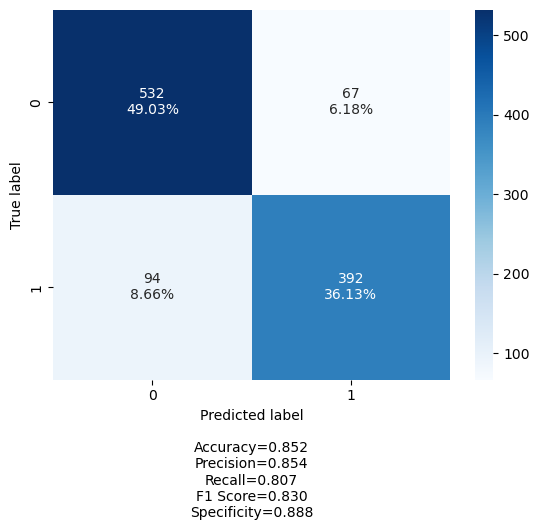

In [ ]:
test(data_val_600_dl)

## Test on dataset with length 215 </div>

In [ ]:
PATH = "ResidualNN_215.pth"

model = ResidualNN_215()
model.load_state_dict(torch.load(PATH))
model.eval()

ResidualNN_215(
  (conv1): Conv2d(2, 16, kernel_size=(1, 1), stride=(1, 1))
  (res1): ResidualBlock(
    (conv1): Sequential(
      (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), padding=same, dilation=(2, 2))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (relu): ReLU()
    (batch_norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res2): ResidualBlock(
    (conv1): Sequential(
      (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), padding=same, dilation=(4, 4))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (relu): ReLU()
    (batch_norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=7952, out_fe

100%|██████████| 200/200 [00:01<00:00, 166.17it/s]


Accuracy of the network on the 10000 test images: 76 %


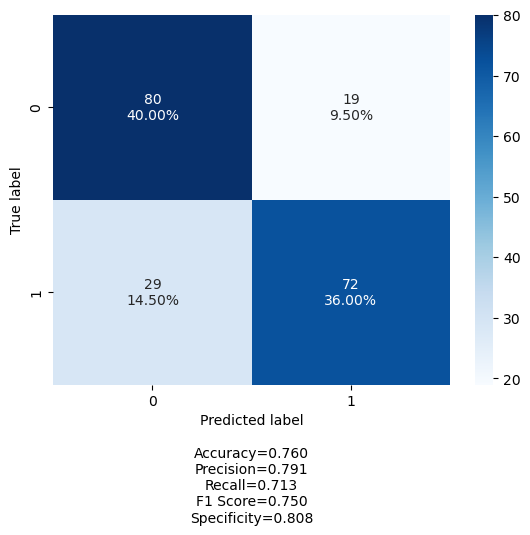

In [ ]:
test(data_val_215_dl)

## Test on dataset cut around the mutation with different length </div>

In [ ]:
data_val_cut_5_ds = ProteinDataset(data_val_cut_5, VAL_CUT_5, SEQUENCE_215, transform=transfrom_data)
data_val_cut_10_ds = ProteinDataset(data_val_cut_10, VAL_CUT_10, SEQUENCE_215, transform=transfrom_data)
data_val_cut_20_ds = ProteinDataset(data_val_cut_20, VAL_CUT_20, SEQUENCE_215, transform=transfrom_data)
data_val_cut_50_ds = ProteinDataset(data_val_cut_50, VAL_CUT_50, SEQUENCE_215, transform=transfrom_data)

In [ ]:
data_val_cut_5_dl = DataLoader(data_val_cut_5_ds, batch_size = 1)
data_val_cut_10_dl = DataLoader(data_val_cut_10_ds, batch_size = 1)
data_val_cut_20_dl = DataLoader(data_val_cut_20_ds, batch_size = 1)
data_val_cut_50_dl = DataLoader(data_val_cut_50_ds, batch_size = 1)

100%|██████████| 200/200 [00:01<00:00, 143.28it/s]


Accuracy of the network on the 10000 test images: 57 %


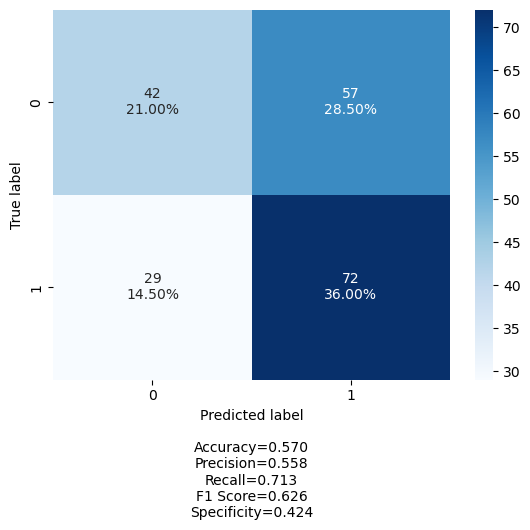

In [ ]:
test(data_val_cut_5_dl)

100%|██████████| 200/200 [00:01<00:00, 143.05it/s]


Accuracy of the network on the 10000 test images: 50 %


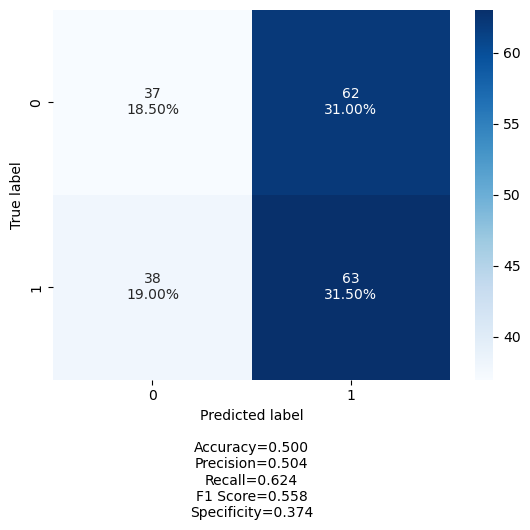

In [ ]:
test(data_val_cut_10_dl)

100%|██████████| 200/200 [00:01<00:00, 159.20it/s]


Accuracy of the network on the 10000 test images: 53 %


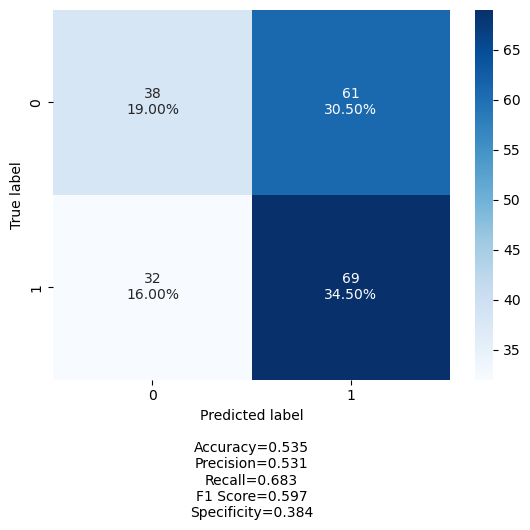

In [ ]:
test(data_val_cut_20_dl)

100%|██████████| 200/200 [00:01<00:00, 188.99it/s]


Accuracy of the network on the 10000 test images: 53 %


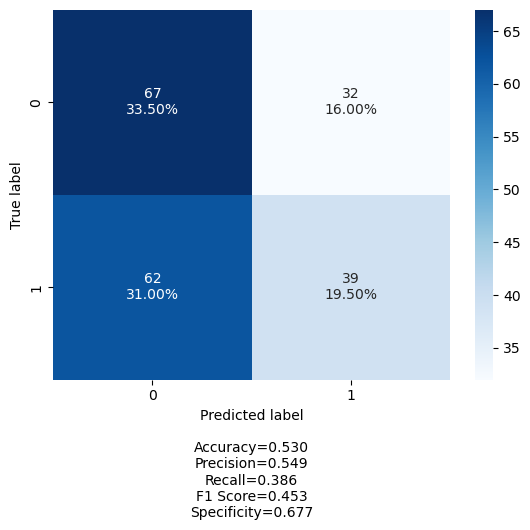

In [ ]:
test(data_val_cut_50_dl)

# 3 |</span></b> Convolutional Neural Network </div>

# 3.1 |</span></b> Load Data </div>

We use the same input format as before

In [ ]:
data_train_600_dl = DataLoader(data_train_600_ds, batch_size=4)
data_val_600_dl = DataLoader(data_val_600_ds, batch_size=1)

data_train_215_dl = DataLoader(data_train_215_ds, batch_size=2)
data_val_215_dl = DataLoader(data_val_215_ds, batch_size=2)

In [ ]:
inputs, labels = next(iter(data_train_215_dl))
inputs.shape

torch.Size([2, 2, 215, 21])

# 3.2 |</span></b> Define the model </div>


In [ ]:
# Useful Function to calculate the output size of a CNN layer
# before making it an input into the linear layer

def findConv2dOutShape(hin,win,conv,pool=0):
    # get conv arguments
    kernel_size=conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    hout=np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    wout=np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        hout/=pool
        wout/=pool
    return int(hout),int(wout)

In [ ]:
class Network(nn.Module):
    
    # Network Initialisation
    def __init__(self, params):
        
        super(Network, self).__init__()
    
        Cin,Hin,Win=params["shape_in"]
        init_f=params["initial_filters"] 
        num_fc1=params["num_fc1"]  
        num_classes=params["num_classes"] 
        self.dropout_rate=params["dropout_rate"] 
        
        # Convolution Layers
        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3, stride=2)
        h,w=findConv2dOutShape(Hin,Win,self.conv1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3, stride=3)
        h,w=findConv2dOutShape(h,w,self.conv2)
        
        # compute the flatten size
        self.num_flatten=h*w*2*init_f
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self,X):
        
        # Convolution & Pool Layers
        X = F.relu(self.conv1(X))
        X = F.relu(self.conv2(X))

        X = X.view(X.size(0), -1)
        
        X = F.relu(self.fc1(X))
        X=F.dropout(X, self.dropout_rate)
        X = self.fc2(X)
        return F.log_softmax(X, dim=1)
    

In [ ]:
print(model)

Network(
  (conv1): Conv2d(2, 90, kernel_size=(3, 3), stride=(2, 2))
  (conv2): Conv2d(90, 180, kernel_size=(3, 3), stride=(3, 3))
  (fc1): Linear(in_features=18900, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=2, bias=True)
)


#  <style> 
    .ma-classe {
    font-size: 30px;
}
</style>
<div class="alert alert-success">3.3 |</span></b> Define the loss function, the optimizer and the hyperparameter</div>


In [ ]:
# Neural Network Predefined Parameters
params_model={
        "shape_in": tuple(inputs.shape[1:]), 
        "initial_filters": 90,    
        "num_fc1": 1000,
        "dropout_rate": 0.25,
        "num_classes": 2}

# Create instantiation of Network class
cnn_model = Network(params_model)

# define computation hardware approach (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = cnn_model.to(device)
loss_func = nn.NLLLoss(reduction="sum")

In [ ]:
from torch import optim
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

#  <style> 
    .ma-classe {
    font-size: 30px;
}
</style>
<div class="alert alert-success">3.5 |</span></b> Training </div>


## 3.5.1 |</span></b> Helpers function </div>


In [ ]:
''' Helper Functions'''

# Function to get the learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# Function to compute the loss value per batch of data
def loss_batch(loss_func, output, target, opt=None):

    loss = loss_func(output, target) # get loss
    pred = output.argmax(dim=1, keepdim=True) # Get Output Class
    #print("pred : ", pred[:,0])
    #print("target : ", target)
    metric_b=pred.eq(target.view_as(pred)).sum().item() # get performance metric
    #print('acc : ', acc)
    #print('f1 : ', f1)
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

# Compute the loss value & performance metric for the entire dataset (epoch)
def loss_epoch(model,loss_func,dataset_dl,check=False,opt=None):
    
    run_loss=0.0 
    t_metric=0.0
    acc_metric=0.0
    f1_metric=0.0

    len_data=len(dataset_dl.dataset)

    # internal loop over dataset
    for xb, yb in tqdm(dataset_dl):
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb) # get model output
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt) # get loss per batch
        run_loss+=loss_b        # update running loss

        if metric_b is not None: # update running metric
            t_metric+=metric_b
            

        # break the loop in case of sanity check
        if check is True:
            break
    
    loss=run_loss/float(len_data)  # average loss value
    metric=t_metric/float(len_data) # average metric value
    
    return loss, metric

## 3.5.2 |</span></b> Train function</div>

In [ ]:
def train_val(model, params,verbose=True):
    
    # Get the parameters
    epochs=params["epochs"]
    loss_func=params["f_loss"]
    opt=params["optimiser"]
    train_dl=params["train"]
    val_dl=params["val"]
    check=params["check"]
    lr_scheduler=params["lr_change"]
    weight_path=params["weight_path"]
    
    loss_history={"train": [],"val": []} # history of loss values in each epoch
    metric_history={"train": [],"val": []} # histroy of metric values in each epoch
    best_model_wts = copy.deepcopy(model.state_dict()) # a deep copy of weights for the best performing model
    best_loss=float('inf') # initialize best loss to a large value


    # first step
    train_loss, train_metric=loss_epoch(model,loss_func,train_dl,check,opt)
    val_loss, val_metric=loss_epoch(model,loss_func,val_dl,check)
    metric_history["train"].append(train_metric)
    metric_history["val"].append(val_metric)
    
    # main loop
    for epoch in range(1, epochs+1):
        
        ''' Get the Learning Rate '''
        current_lr=get_lr(opt)
        if(verbose):
            print('Epoch {}/{}, current lr={}'.format(epoch, epochs, current_lr))
        
        ''' Train the Model on the Training Set '''
        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,train_dl,check,opt)

        ''' Collect loss and metric for training dataset ''' 
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        ''' Evaluate model on validation dataset '''
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,val_dl,check)
        
        # store best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # store weights into a local file
            torch.save(model.state_dict(), weight_path)
            if(verbose):
                print("Copied best model weights!")
        
        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        # learning rate schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            if(verbose):
                print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 

        if(verbose):
            print(f"train loss: {train_loss:.6f}, val loss: {val_loss:.6f}, acc: {100*val_metric:.4g}")
            print("-"*10) 
        
        if(val_metric>0.87):
            break
        

    # load best model weights
    model.load_state_dict(best_model_wts)

    torch.save(model.state_dict(), "saved_models/model_seq_215")
        
    return model, loss_history, metric_history

In [ ]:
params_train={
 "train": data_train_215_dl,"val": data_val_215_dl,
 "epochs": 3,
 "optimiser": optim.Adam(cnn_model.parameters(),
                         lr=3e-4),
 "lr_change": ReduceLROnPlateau(opt,
                                mode='min',
                                factor=0.5,
                                patience=20,
                                verbose=1),
 "f_loss": nn.NLLLoss(reduction="sum"),
 "weight_path": "weights.pt",
 "check": False, 
}

''' Actual Train / Evaluation of CNN Model '''
# train and validate the model
cnn_model,loss_hist,metric_hist=train_val(cnn_model,params_train)

100%|██████████| 100/100 [00:01<00:00, 62.17it/s]


Epoch 1/3, current lr=0.0003


100%|██████████| 100/100 [00:01<00:00, 67.62it/s]


Copied best model weights!
train loss: 0.408756, val loss: 0.524324, acc: 78
----------
Epoch 2/3, current lr=0.0003


100%|██████████| 100/100 [00:01<00:00, 83.17it/s]


Copied best model weights!
train loss: 0.317788, val loss: 0.486449, acc: 78.5
----------
Epoch 3/3, current lr=0.0003


100%|██████████| 100/100 [00:01<00:00, 78.36it/s]


train loss: 0.276635, val loss: 0.578912, acc: 77
----------


In [ ]:
torch.save(model.state_dict(), "saved_models/model_seq_215")

In [ ]:
# Train-Validation Progress
epochs=params_train["epochs"]

fig = make_subplots(rows=1, cols=2,subplot_titles=['lost_hist','metric_hist'])
fig.add_trace(go.Scatter(x=[*range(0,epochs+1)], y=loss_hist["train"],name='loss_hist["train"]'),row=1, col=1)
fig.add_trace(go.Scatter(x=[*range(0,epochs+1)], y=loss_hist["val"],name='loss_hist["val"]'),row=1, col=1)
fig.add_trace(go.Scatter(x=[*range(0,epochs+1)], y=metric_hist["train"],name='metric_hist["train"]'),row=1, col=2)
fig.add_trace(go.Scatter(x=[*range(0,epochs+1)], y=metric_hist["val"],name='metric_hist["val"]'),row=1, col=2)
fig.update_layout(template='plotly_white');fig.update_layout(margin={"r":0,"t":60,"l":0,"b":0},height=300)
fig.show()

#  <style> 
    .ma-classe {
    font-size: 30px;
}
</style>
<div class="alert alert-success">3.6 |</span></b> Testing </div>


# <style> 
    .ma-classe {
    font-size: 10 px;
}
</style>
<div class="alert alert-warning">  Test on dataset with length less than 600 </div>


Load the model with trained on sequences of length 600 during 3 epochs.

In [ ]:
inputs, labels = next(iter(data_train_600_dl))

# Neural Network Predefined Parameters
params_model={
        "shape_in": tuple(inputs.shape[1:]), 
        "initial_filters": 90,    
        "num_fc1": 1000,
        "dropout_rate": 0.25,
        "num_classes": 2}

# Create instantiation of Network class
model = Network(params_model)

model.load_state_dict(torch.load("saved_models/model_seq_600"))
model.eval()

Network(
  (conv1): Conv2d(2, 90, kernel_size=(3, 3), stride=(2, 2))
  (conv2): Conv2d(90, 180, kernel_size=(3, 3), stride=(3, 3))
  (fc1): Linear(in_features=53460, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=2, bias=True)
)

100%|██████████| 1085/1085 [00:21<00:00, 49.44it/s]


Accuracy of the network on the 10000 test images: 88 %


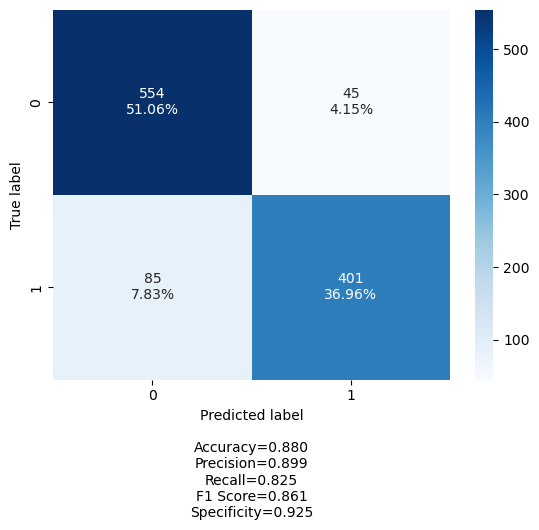

In [ ]:
''' Helper Functions'''

# Compute the prediction
test(data_val_600_dl)

### Load the model trained with sequences of lengths 215

In [ ]:
inputs, labels = next(iter(data_train_215_dl))

# Neural Network Predefined Parameters
params_model={
        "shape_in": tuple(inputs.shape[1:]), 
        "initial_filters": 90,    
        "num_fc1": 1000,
        "dropout_rate": 0.25,
        "num_classes": 2}

# Create instantiation of Network class
model = Network(params_model)

model.load_state_dict(torch.load("saved_models/model_seq_215"))
model.eval()

Network(
  (conv1): Conv2d(2, 90, kernel_size=(3, 3), stride=(2, 2))
  (conv2): Conv2d(90, 180, kernel_size=(3, 3), stride=(3, 3))
  (fc1): Linear(in_features=18900, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=2, bias=True)
)

100%|██████████| 100/100 [00:01<00:00, 67.48it/s]


Accuracy of the network on the 10000 test images: 78 %


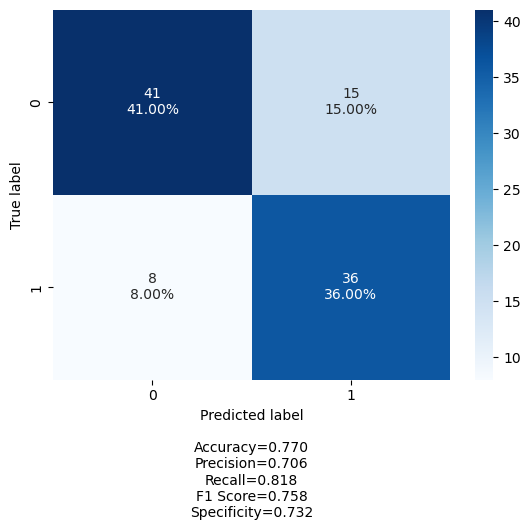

In [ ]:
test(data_val_215_dl)

## Test the model on the cutted sequences

100%|██████████| 200/200 [00:01<00:00, 128.42it/s]


Accuracy of the network on the 10000 test images: 51 %


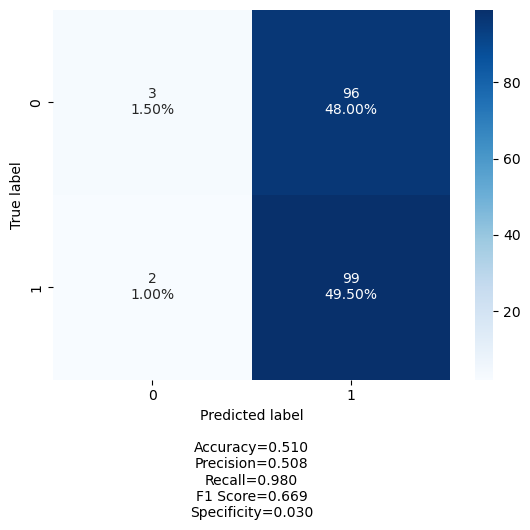

In [ ]:
test(data_val_cut_5_dl)

100%|██████████| 200/200 [00:01<00:00, 124.93it/s]


Accuracy of the network on the 10000 test images: 49 %


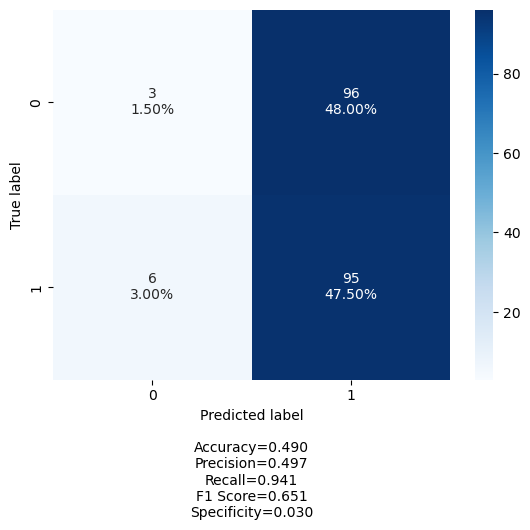

In [ ]:
test(data_val_cut_10_dl)

100%|██████████| 200/200 [00:01<00:00, 126.78it/s]


Accuracy of the network on the 10000 test images: 46 %


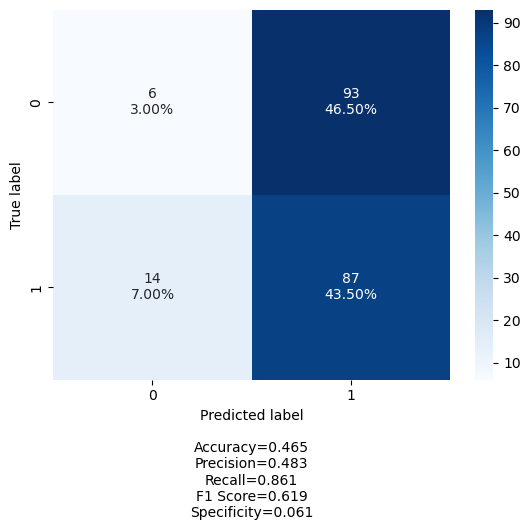

In [ ]:
test(data_val_cut_20_dl)

100%|██████████| 200/200 [00:01<00:00, 124.31it/s]


Accuracy of the network on the 10000 test images: 51 %


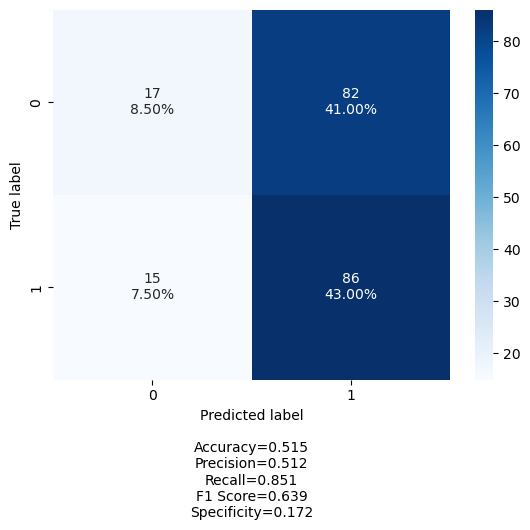

In [ ]:
test(data_val_cut_50_dl)